In [1]:
import numpy as np
import pandas as pd
import cProfile
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import GroupKFold, train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import time
from scipy.stats import pearsonr

from split import prep_data_before_train, random_split, subset

data = pd.read_feather("../data/processed/massBV.feather")

X, y, ringnrs, mean_pheno = prep_data_before_train(data, "mass")
del data
X.drop(columns = ["hatchisland"], inplace = True)
X["ringnr"] = ringnrs   

target = pd.DataFrame(y)
target["mean_pheno"] = mean_pheno
target["ringnr"] = ringnrs

folds = random_split("mass", num_folds=10, seed=42)

X = pd.merge(X,folds, on = "ringnr", how = "inner") 
X = pd.merge(X,target, on = "ringnr", how = "inner")



In [2]:
def run_xgb(X_train, y_train, X_val, y_val):
    xgb_params = {
        "objective": "reg:pseudohubererror", 
    }

    model = xgb.XGBRegressor(**xgb_params)  
    model.fit(X_train, y_train["ID"])
    preds = model.predict(X_val)
    corr, _ = pearsonr(preds, y_val["mean_pheno"])
    return corr

def run_lgb(X_train, y_train, X_val, y_val):
    lgb_params = {
        "objective": "huber",
        "alpha": 1.0   
    }

    model = lgb.LGBMRegressor(**lgb_params)  
    model.fit(X_train, y_train["ID"])
    preds = model.predict(X_val)
    corr, _ = pearsonr(preds, y_val["mean_pheno"])
    return corr 

def run_cb(X_train, y_train, X_val, y_val):
    cb_params = {
        "loss_function": "Huber:delta=1"
    }

    model = cb.CatBoostRegressor(**cb_params, verbose = 0)  
    model.fit(X_train, y_train["ID"])
    preds = model.predict(X_val)
    corr, _ = pearsonr(preds, y_val["mean_pheno"])
    return corr

# Using KFold cross-validation
def cross_val_run(model_fn, X_data, y_data):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold_corrs = []

    for train_idx, val_idx in kf.split(X_data):
        X_train, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
        y_train, y_val = y_data.iloc[train_idx], y_data.iloc[val_idx]
        corr = model_fn(X_train, y_train, X_val, y_val)
        fold_corrs.append(corr)

    return fold_corrs


In [3]:
#subset_sizes = [20, 50, 100, 200, 300, 500, 2000, 5000, 10000, 20000, 25000]
#subset_sizes = np.arange(1000, 27000, 2500)
subset_sizes = [10,20,30,50,90,160,280,500,900,1500,2600,4700,8200,14300,25000]
#do it for logscale as well


xgb_corr = []
lgb_corr = []
cb_corr = []

for size in subset_sizes:
    print(size)
    X_sub = subset(X, num_snps=size)
    print(X_sub.shape)

    X_data = X_sub.drop(columns=["ringnr", "ID", "fold", "mean_pheno"])
    y_data = X_sub[["ID", "mean_pheno"]]

    # Run 5-fold CV for each model and store results
    xgb_corr.append(cross_val_run(run_xgb, X_data, y_data))
    lgb_corr.append(cross_val_run(run_lgb, X_data, y_data))
    cb_corr.append(cross_val_run(run_cb, X_data, y_data))

    print("XGB correlations: ", xgb_corr)
    print("LGB correlations: ", lgb_corr)
    print("CB correlations: ", cb_corr)

10
(1918, 14)
XGB correlations:  [[0.02332738544851537, -0.05103427323611832, -0.013075322170132485, 0.03468423775097439, -0.03346923517201485, 0.05028204119220346, -0.010645524015281675, 0.036861719903890144, 0.07868687549454442, 0.04638997512702439]]
LGB correlations:  [[-0.026999439050933514, -0.06582196941304366, 0.03924775657588052, 0.0394534267746779, -0.05519316526926681, 0.11831296428967411, -0.04757777168205353, -0.012715106752517996, 0.03785834559790336, 0.052776077628717964]]
CB correlations:  [[-0.02088566512837696, -0.06766414486108956, 0.041474494438690966, 0.029666334062760875, -0.06241933938471542, 0.04304537471857825, -0.06221669471115129, -0.016945131973655568, 0.09568941549415662, 0.07257909058070178]]
20
(1918, 24)
XGB correlations:  [[0.02332738544851537, -0.05103427323611832, -0.013075322170132485, 0.03468423775097439, -0.03346923517201485, 0.05028204119220346, -0.010645524015281675, 0.036861719903890144, 0.07868687549454442, 0.04638997512702439], [0.0190222253341

### Plots

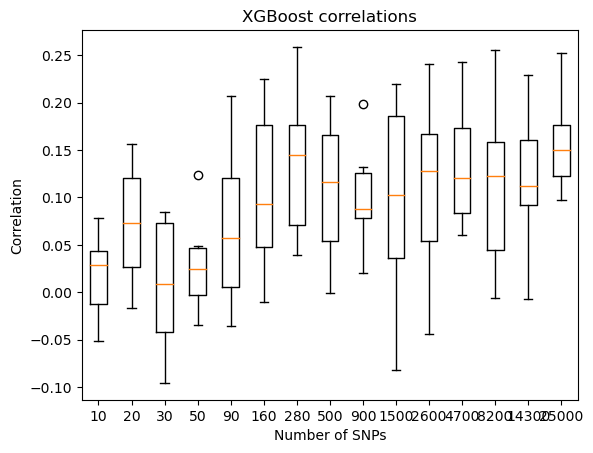

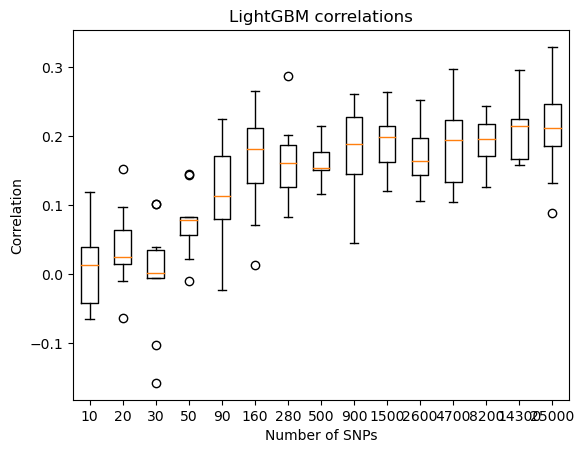

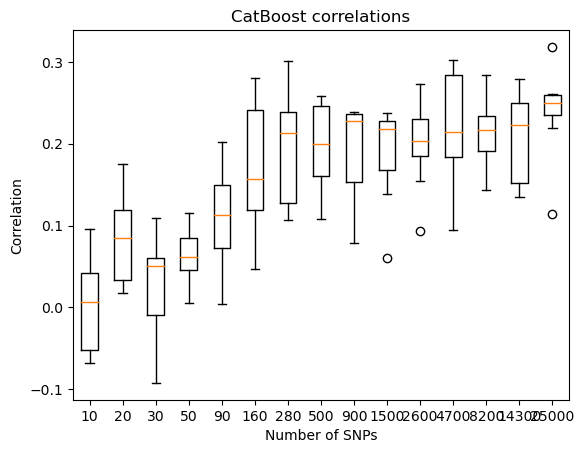

In [4]:
#plot results as boxplots
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot(xgb_corr)
plt.xticks(range(1, len(subset_sizes)+1), subset_sizes)
plt.title("XGBoost correlations")
plt.xlabel("Number of SNPs")
plt.ylabel("Correlation")
plt.show()

plt.figure()
plt.boxplot(lgb_corr)
plt.xticks(range(1, len(subset_sizes)+1), subset_sizes)
plt.title("LightGBM correlations")
plt.xlabel("Number of SNPs")
plt.ylabel("Correlation")
plt.show()

plt.figure()
plt.boxplot(cb_corr)
plt.xticks(range(1, len(subset_sizes)+1), subset_sizes)
plt.title("CatBoost correlations")
plt.xlabel("Number of SNPs")
plt.ylabel("Correlation")
plt.show()

In [5]:
# Save results to file for later use
np.save("../data/results/xgb_corr_log_mass.npy", xgb_corr)
np.save("../data/results/lgb_corr_log_mass.npy", lgb_corr)
np.save("../data/results/cb_corr_log_mass.npy", cb_corr)